# Predicting Index Price of DJIA only w/ Historical Data

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

from pandas_datareader.data import DataReader


In [2]:
import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)


### Load Data

In [17]:
# Define time period
# Match with financial news data

start = datetime(2017, 12, 16)
end = datetime(2020, 7, 18)
dataset = yf.download("^DJI", start, end)


[*********************100%%**********************]  1 of 1 completed


In [18]:
# Visualize raw dataset

dataset


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-18,24739.560547,24876.070312,24739.560547,24792.199219,24792.199219,354880000
2017-12-19,24834.380859,24850.109375,24715.599609,24754.750000,24754.750000,335330000
2017-12-20,24838.089844,24852.439453,24697.109375,24726.650391,24726.650391,341790000
2017-12-21,24778.259766,24850.910156,24766.269531,24782.289062,24782.289062,339530000
2017-12-22,24764.039062,24784.150391,24717.509766,24754.060547,24754.060547,255140000
...,...,...,...,...,...,...
2020-07-13,26225.070312,26639.089844,26044.230469,26085.800781,26085.800781,425320000
2020-07-14,26044.169922,26690.519531,25994.980469,26642.589844,26642.589844,401640000
2020-07-15,27009.810547,27071.330078,26692.480469,26870.099609,26870.099609,384900000


In [19]:
dates_list = dataset.index.tolist()
dates_list

[Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-12-19 00:00:00'),
 Timestamp('2017-12-20 00:00:00'),
 Timestamp('2017-12-21 00:00:00'),
 Timestamp('2017-12-22 00:00:00'),
 Timestamp('2017-12-26 00:00:00'),
 Timestamp('2017-12-27 00:00:00'),
 Timestamp('2017-12-28 00:00:00'),
 Timestamp('2017-12-29 00:00:00'),
 Timestamp('2018-01-02 00:00:00'),
 Timestamp('2018-01-03 00:00:00'),
 Timestamp('2018-01-04 00:00:00'),
 Timestamp('2018-01-05 00:00:00'),
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-09 00:00:00'),
 Timestamp('2018-01-10 00:00:00'),
 Timestamp('2018-01-11 00:00:00'),
 Timestamp('2018-01-12 00:00:00'),
 Timestamp('2018-01-16 00:00:00'),
 Timestamp('2018-01-17 00:00:00'),
 Timestamp('2018-01-18 00:00:00'),
 Timestamp('2018-01-19 00:00:00'),
 Timestamp('2018-01-22 00:00:00'),
 Timestamp('2018-01-23 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-01-25 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-01-

### Split into Train and Test

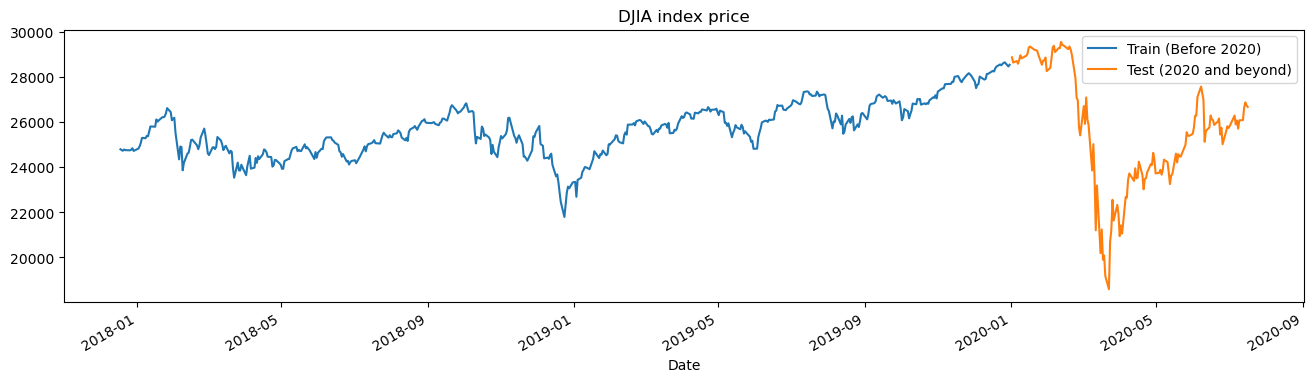

In [53]:
# split dataset for 2020 and beyond in test

tstart = 2017
tend = 2019

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Close"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "Close"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("DJIA index price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [74]:
# Split the orginial dataframe into training and testing segments

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Close"]
    test = dataset.loc[f"{tend+1}":, "Close"]
    return train, test

def train_test_split_values(dataset, tstart, tend):
    train, test =  train_test_split(dataset, tstart, tend)
    return train.values, test.values

training_set, test_set = train_test_split_values(dataset, tstart, tend)


In [75]:
# Scaling the training and test set

sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

test_set = test_set.reshape(-1, 1)
test_set_scaled = sc.fit_transform(test_set)


In [76]:
# Split the data into vectors X (sequences of length 40) and Y (next price target)

def split_sequence(sequence, window):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 40 # arbitrary
features = 1

# Call for both training and test set

X_train, y_train = split_sequence(training_set_scaled, window_size)
X_test, y_test = split_sequence(test_set_scaled, window_size)


In [77]:
# Confirmed scaled targets within y_train

y_train


array([[0.49732085],
       [0.50009505],
       [0.46293926],
       [0.43857486],
       [0.46260809],
       [0.51331679],
       [0.5715797 ],
       [0.52791451],
       [0.4723437 ],
       [0.4110253 ],
       [0.40067665],
       [0.44980787],
       [0.45117359],
       [0.43909727],
       [0.45279211],
       [0.51707423],
       [0.49414566],
       [0.46910866],
       [0.43278764],
       [0.44964741],
       [0.46027764],
       [0.41130688],
       [0.42828606],
       [0.42172564],
       [0.31601813],
       [0.25404708],
       [0.35172612],
       [0.30139989],
       [0.30004415],
       [0.33720848],
       [0.27024279],
       [0.32703055],
       [0.36072957],
       [0.39588465],
       [0.31235103],
       [0.31911295],
       [0.38169819],
       [0.34980721],
       [0.39264961],
       [0.37471454],
       [0.40578072],
       [0.43694808],
       [0.43132132],
       [0.41918372],
       [0.38971496],
       [0.3876356 ],
       [0.32568392],
       [0.334

In [78]:
# Reshape X_train and X_test for 2D column vector to 3D input tensor

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)


## LSTM Training and Prediction

In [79]:
# Define model architecture

model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(window_size, features)))
model_lstm.add(Dense(25))
model_lstm.add(Dense(units=1)) # final dense layer (1) predicts value for target price

model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_3 (Dense)             (None, 25)                3150      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 66676 (260.45 KB)
Trainable params: 66676 (260.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
# Train model

model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)


Epoch 1/15
15/15 [==============================] - 1s 19ms/step - loss: 0.0839
Epoch 2/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0093
Epoch 3/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0050
Epoch 4/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0040
Epoch 5/15
15/15 [==============================] - 0s 19ms/step - loss: 0.0036
Epoch 6/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0034
Epoch 7/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0033
Epoch 8/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0031
Epoch 9/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0030
Epoch 10/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0029
Epoch 11/15
15/15 [==============================] - 0s 18ms/step - loss: 0.0028
Epoch 12/15
15/15 [==============================] - 0s 21ms/step - loss: 0.0027
Epoch 13/15
15/15 [==================

In [81]:
# Make predictions on test set

predicted_index_price = model_lstm.predict(X_test)


4/4 [==============================] - 0s 5ms/step


In [82]:
# Inverse transform both y_test and predicted_index_price

y_test_inv = sc.inverse_transform(y_test)
predicted_index_price_inv = sc.inverse_transform(predicted_index_price)


In [83]:
# Visualize y_test and predicted_index prices following transform

print(y_test_inv[:20], "\n\n")
print(predicted_index_price_inv[:20])


[[26703.3203125 ]
 [25917.41015625]
 [27090.859375  ]
 [26121.27929688]
 [25864.77929688]
 [23851.01953125]
 [25018.16015625]
 [23553.22070312]
 [21200.61914062]
 [23185.61914062]
 [20188.51953125]
 [21237.38085938]
 [19898.91992188]
 [20087.18945312]
 [19173.98046875]
 [18591.9296875 ]
 [20704.91015625]
 [21200.55078125]
 [22552.16992188]
 [21636.77929688]] 


[[27013.48 ]
 [26719.87 ]
 [26406.195]
 [26389.865]
 [26282.363]
 [26160.305]
 [25695.143]
 [25444.95 ]
 [24995.602]
 [24171.434]
 [23741.734]
 [22923.092]
 [22363.521]
 [21714.295]
 [21208.133]
 [20676.39 ]
 [20154.635]
 [20074.412]
 [20205.195]
 [20637.273]]


In [94]:
# Helper functions for plotting model predictions vs true index prices

def plot_predictions(test, predicted, model_type):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(f"Index Price Prediction for {model_type} model")
    plt.xlabel("Days following Jan 1st, 2020")
    plt.ylabel("Index Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f} USD.".format(rmse))
    

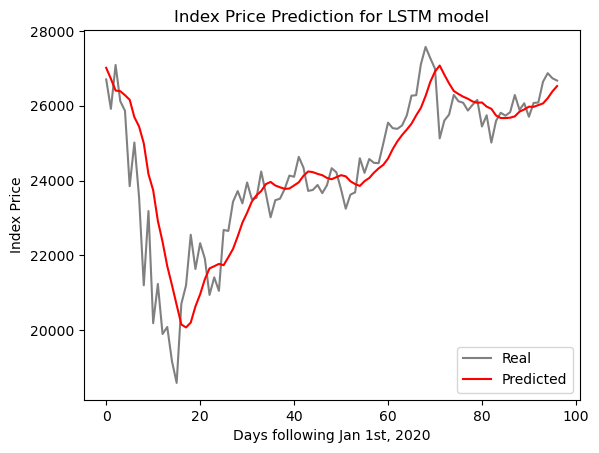

In [95]:
# Display predictions plot

plot_predictions(y_test_inv, predicted_index_price_inv, "LSTM")


**Comments:** From the plot above, we observe that our benchmark LSTM model trained solely on historical financial data (no financial news sentiment features) was able to decently predict low-frequency trends in DJIA index price shifts. The model predicted the continued drop while the economy recovered from the COVID-19 pandemic along with an approximation of the inflection point around the 17th day.

In [87]:
# Display root mean squared error from the prediction

return_rmse(y_test_inv, predicted_index_price_inv)


The root mean squared error is 994.03 USD.


## GRU Training and Prediction

In [88]:
# Define model architecture

model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(window_size, features)))
model_gru.add(Dense(units=1)) # dense layer outputs target index price

model_gru.compile(optimizer="adam", loss="mse")

model_gru.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 125)               48000     
                                                                 
 dense_5 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
# Train model

model_gru.fit(X_train, y_train, epochs=15, batch_size=32)


Epoch 1/15
15/15 [==============================] - 1s 16ms/step - loss: 0.1236
Epoch 2/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0127
Epoch 3/15
15/15 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 4/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 5/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0039
Epoch 6/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0034
Epoch 7/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 8/15
15/15 [==============================] - 0s 16ms/step - loss: 0.0026
Epoch 9/15
15/15 [==============================] - 0s 15ms/step - loss: 0.0024
Epoch 10/15
15/15 [==============================] - 0s 15ms/step - loss: 0.0022
Epoch 11/15
15/15 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 12/15
15/15 [==============================] - 0s 15ms/step - loss: 0.0020
Epoch 13/15
15/15 [==================

In [90]:
# Model predictions and inverse transform

GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price_inv = sc.inverse_transform(GRU_predicted_stock_price)
# y_test inverse transform stored from earlier


4/4 [==============================] - 0s 4ms/step


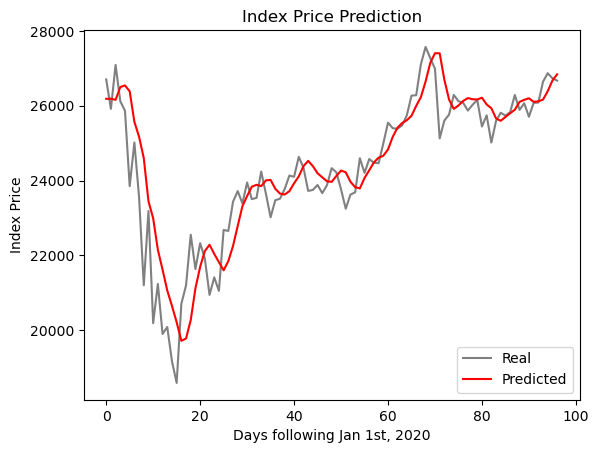

In [91]:
# Display predictions plot

plot_predictions(y_test_inv, GRU_predicted_stock_price_inv, "GRU")


**Comments:** Based on the plot above, we can conclude that the GRU model captured a greater extent of high-frequency fluctions in DJIA index prices compared to that of our LSTM model before. Both models serve as a benchmark from which we can visually determine and quantify via RMSE (below) the improvements achieved by including features infinancial news sentiment.

In [93]:
# Report root mean squared error

return_rmse(y_test_inv,GRU_predicted_stock_price_inv)


The root mean squared error is 873.48 USD.
